# Tutorial: Train and evaluate a model on with images of spots

## Spot generation

First, we need to generate our dataset. For this we use the data generator provided in the package.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

import matplotlib.patches as patches
from matplotlib import colormaps as cmaps
import os
from tqdm import tqdm
import yaml
from importlib import reload  # Python 3.4+
import pandas as pd

import image_generator as ig

from yundon_functions import *
pi = np.pi
from multiprocessing import Pool
from PIL import Image
from cv2 import resize
from itertools import repeat
from matplotlib.patches import Rectangle, Circle
# %matplotlib widget
import cv2
from ultralytics.utils import ops


def plot_result(ax,img,objects, vmin=1.95e4, vmax=2.05e4):
    if isinstance(img, PIL.Image.Image) or isinstance(img, np.ndarray):
        pass
    elif(type(img) == str):
        img = PIL.Image.open(img)
    ax.imshow(img,cmap="grey",vmin=vmin,vmax=vmax)
    ax.axis("off")
    for i,obj in objects.iterrows():
        l,x,y,w,h = obj[:5]
        rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="yellow", facecolor='none')
        tx,ty = rect.get_xy()
        ax.add_patch(rect)
        tx+=6
        ty-=12
        circle = Circle((x,y),1, facecolor="red",edgecolor="red")
        ax.add_patch(circle)
        if l == "Ripple":
            ax.text(tx,ty,f"{obj["z"]*0.134:.3f}",fontsize="small",bbox=dict(facecolor='white', alpha=0.5,))
def plot_gt(path,ax,imgsz=[512,512],vmin=1.95e4,vmax=2.05e4):
    data=np.atleast_2d(np.loadtxt(path.replace("images", "labels").replace("jpg","txt").replace("tif","txt"))).T
    # print(data)
    if(len(data)==0):
         return plot_result(ax,path, np.empty(0),np.empty((0,4)),np.empty(0),np.empty((0,0)),vmin=vmin,vmax=vmax)
    cls = data[0]
    bboxes = data[1:5].T*(imgsz*2)
    z = data[5]
    kpts = data[7:].T*imgsz
    # print(bboxes)
    
    return plot_result(ax,path, cls,bboxes,z,kpts, vmin=vmin,vmax=vmax)

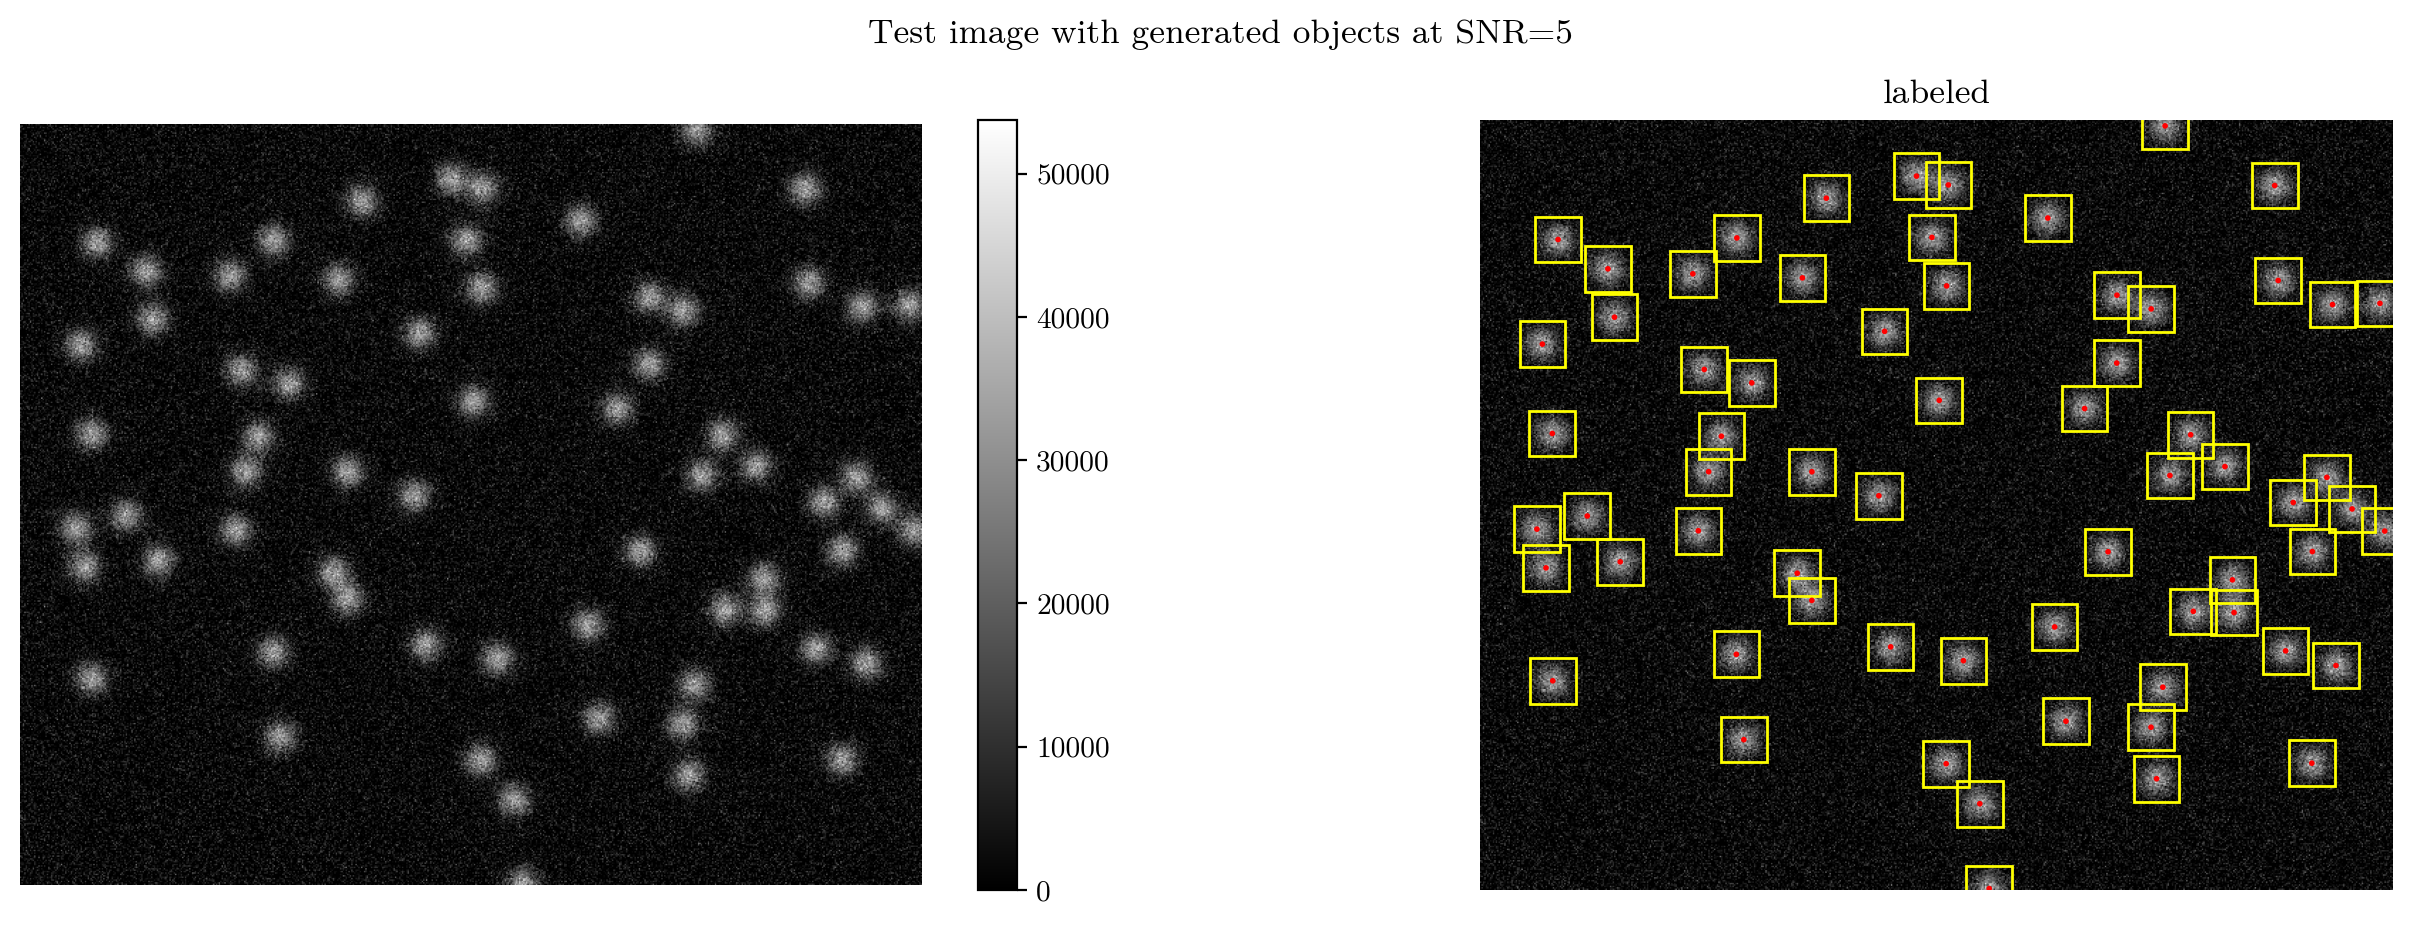

   label           x           y   w   h             i  s
0   Spot  582.803059  450.646852  32  32  32767.310194  8
1   Spot  338.485862  378.792683  32  32  32767.390046  8
2   Spot  499.688936  344.170586  32  32  32768.818425  8
3   Spot   89.162469  103.972775  32  32  32765.541459  8
4   Spot   43.183581  156.771007  32  32  32768.041847  8
..   ...         ...         ...  ..  ..           ... ..
61  Spot  179.588831   82.306793  32  32  32770.168981  8
62  Spot  470.131391  132.078602  32  32  32766.958940  8
63  Spot  327.914405   45.142683  32  32  32769.269676  8
64  Spot  287.459739  369.075568  32  32  32767.199348  8
65  Spot  356.549145  538.574278  32  32  32767.588308  8

[66 rows x 7 columns]


In [4]:
import image_generator as ig

spot_params = {"label":"Spot", "i":("gaussian", [2**15]), "s":8, "n":(30,90)} # Parameters for the image generator
parameter_list = [spot_params]
image_size = 540,640       # Dimension 
distance = 20               # Min distance between points to avoid overlap
offset = 0                # Boundary padding
snr = 5


objects = ig.getRandom(parameter_list, image_size, distance=distance, offset=offset) # Generate object positions for test image
image,_ = ig.generateImage(objects, image_size,snr=float(snr), background=0)                 # Generate image with objects

# Plot test image
plt.close("all")
plt.figure(figsize=(16,5))
ax = plt.subplot(1,2,1)
ax.axis("off")
plt.imshow(image, cmap="grey")
plt.colorbar()

ax = plt.subplot(1,2,2)
plt.title("labeled")
plot_result(ax,image,objects, vmin=image.min(), vmax=image.max())
ax.axis("off")

# plt.tight_layout()
plt.suptitle(f"Test image with generated objects at SNR={snr}")
plt.show()

print(objects)



Now, let's generate some training data!

In [ ]:
subdir = '../datasets/Dataset_spots/'
nimages = [10000,1000, 10000,1000]
folders = ["train_snr8-12","val_snr8-12", "train_snr15-20","val_snr15-20"] #the names for our folders
snr_range = [[8,12], [8,12], [15,20], [15,20]] # SNR range for the training and validation sets

import time
reload(ig)
if not os.path.exists(subdir):
    os.mkdir(subdir)

l_dir = subdir  + 'labels'
i_dir = subdir + 'images'
if not os.path.exists(i_dir):
    os.mkdir(i_dir)
if not os.path.exists(l_dir):
    os.mkdir(l_dir)
for i, prefix in enumerate(folders):
    image_dir = i_dir + '/' + prefix + '/'
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)
    label_dir = l_dir + '/' + prefix + '/'
    if not os.path.exists(label_dir):
        os.mkdir(label_dir)
for i, prefix in enumerate(folders):
    vectorized_index = np.vectorize(lambda labels,item: labels.index(item))
    rngs = []
    def init():
        # Initialize the random number generator for each process
        global rng #the rng variable is global so that it can be used in the call function
        rng = np.random.default_rng()
        time.sleep(rng.uniform(0,2))
    def call(j):
        labelname = l_dir + '/' + prefix + '/' + 'image_{:05d}.txt'.format(j,2)    
        fname = i_dir + '/' + prefix + '/' + 'image_{:05d}.tif'.format(j,2)


        objects = ig.getRandom(parameter_list, image_size, rng=rng, offset=offset, distance=distance)

        if(len(objects) == 0):
            f = open(labelname, "w")
            f.write("\n")
            f.close()
            return

        image, info_dict = ig.generateImage(objects, image_size , snr=snr_range, rng=rng)
        image = (image).astype(np.uint16) #cast image to 16 bit uint for tiff
        image = Image.fromarray(image).save(fname, quality=100) # save the current image file to disk

        objects[["x","w"]] /= image_size[1] # scale x and w to [0,1]
        objects[["y","h"]] /= image_size[0] # scale y and h to [0,1]

        # turn label into int:
        objects["label"]=pd.factorize(objects["label"])[0]

        # add keypoint coordinates
        objects[["kpt_x", "kpt_y"]] = objects[["x", "y"]]

        np.savetxt(labelname, objects.values, fmt='%g')# save the labels to disk (in txt files) in the form: class x y w h intensity(unused) size(unused) kpt_x kpt_y
    with Pool(initializer=init) as pool:
        for _ in tqdm(pool.imap_unordered(call,range(nimages[i])),total=nimages[i], desc=prefix):
            pass
    global rng
    rng = np.random.default_rng()

val_snr15-20: 100%|██████████| 1000/1000 [01:08<00:00, 14.57it/s]


For testing, let's also generate data for different SNR levels $\in [1,20]$.

In [ ]:
subdir = '../datasets/Dataset_spots/'
snr_range = [1,20] # SNR range for the test set
levels = 20
nimages = [1000]*levels
test_noiselevels = list(np.linspace(*snr_range, levels))
folders = [f'test_snr{i}' for i in test_noiselevels]
import time
reload(ig)
if not os.path.exists(subdir):
    os.mkdir(subdir)

l_dir = subdir  + 'labels'
i_dir = subdir + 'images'
if not os.path.exists(i_dir):
    os.mkdir(i_dir)
if not os.path.exists(l_dir):
    os.mkdir(l_dir)
for i, prefix in enumerate(folders):
    image_dir = i_dir + '/' + prefix + '/'
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)
    label_dir = l_dir + '/' + prefix + '/'
    if not os.path.exists(label_dir):
        os.mkdir(label_dir)

for i, prefix in enumerate(folders):
    vectorized_index = np.vectorize(lambda labels,item: labels.index(item))
    rngs = []
    def init():
        # Initialize the random number generator for each process
        global rng #the rng variable is global so that it can be used in the call function
        rng = np.random.default_rng()
        time.sleep(rng.uniform(0,2))
    def call(j):
        labelname = l_dir + '/' + prefix + '/' + 'image_{:05d}.txt'.format(j,2)    
        fname = i_dir + '/' + prefix + '/' + 'image_{:05d}.tif'.format(j,2)


        objects = ig.getRandom(parameter_list, image_size, rng=rng, distance=distance, offset=offset)

        if(len(objects) == 0):
            f = open(labelname, "w")
            f.write("\n")
            f.close()
            return

        image, info_dict = ig.generateImage(objects, image_size, snr=test_noiselevels[i], rng=rng)
        image = (image).astype(np.uint16) #cast image to 16 bit uint for tiff
        image = Image.fromarray(image).save(fname, quality=100)
       
        objects[["x","w"]] /= image_size[1] # scale x and w to [0,1]
        objects[["y","h"]] /= image_size[0] # scale y and h to [0,1]

        # turn label into int:
        objects["label"]=pd.factorize(objects["label"])[0]

        # add keypoint coordinates
        objects[["kpt_x", "kpt_y"]] = objects[["x", "y"]]

        np.savetxt(labelname, objects.values, fmt='%g')# save the labels to disk (in txt files) in the form: class x y w h intensity(unused) size(unused) kpt_x kpt_y
    with Pool(initializer=init) as pool:
        for _ in tqdm(pool.imap_unordered(call,range(nimages[i])),total=nimages[i], desc=prefix):
            pass
    global rng
    rng = np.random.default_rng()

test_snr20.0: 100%|██████████| 1000/1000 [01:07<00:00, 14.85it/s]


Generate the corresponding yaml files. These contain metadata about the data.

In [ ]:
subdir = '../datasets/Dataset_spots/'

file_path = '../datasets/spots_snr8-12.yaml'

dict = {}

dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train_snr8-12" #directory of training images
dict["val"]=os.getcwd() + '/' + subdir + "images/" + "val_snr8-12" #directory of validation images
# the label directory is inferred automatically by replacing images/ with labels/

dict["kpt_shape"] = [1,2] #the shape of the keypoints: [n_keypoints, dim]. here, we use 1 keypoint (particle center), having 2 dimensions
dict["num_extra_parameters"] = 2 # extra parameters provided in the data. here: intensity, size
dict["extra_param_names"] = ["intensity", "size"]
dict['nc'] = 1 # number of classes
dict['names'] = ["Spot"] #class names

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True) #store to disk

file_path = '../datasets/spots_snr15-20.yaml'

dict = {}

dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train_snr15-20"
dict["val"]=os.getcwd() + '/' + subdir + "images/" + "val_snr15-20"

dict["kpt_shape"] = [1,2] #the shape of the keypoints: [n_keypoints, dim]. here, we use 1 keypoint (particle center), having 2 dimensions
dict["num_extra_parameters"] = 2 # extra parameters provided in the data. here: intensity, size
dict["extra_param_names"] = ["intensity", "size"]
dict['nc'] = 1 # number of classes
dict['names'] = ["Spot"] #class names

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True)




#for the noise levels, create separate files
levels_dir = subdir+"/levels"
if not os.path.exists(levels_dir):
    os.mkdir(levels_dir)

for folder in folders:
    file_path = levels_dir + f'/dataset_{folder}.yaml'
    print(file_path)

    dict = {}
    i_dir =  os.getcwd() + '/' + subdir + "images/" + folder
    dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train"
    dict["val"]=i_dir
    dict["kpt_shape"] = [1,2]
    dict["num_extra_parameters"] = 2
    dict['nc'] = 1
    dict['names'] = ["Spot"]

    with open(file_path, 'w') as file:
        yaml.dump(dict, file, default_flow_style=True)

Lets now train our model with the dataset!

In [4]:
from YOLOtrack11 import YOLOtrack11

# model = YOLOtrack11("yolo11n_zaxis.yaml")
model = YOLOtrack11("yolo11n_spots.pt")

results = model.train(data="datasets/spots_snr8-12.yaml", epochs=1, imgsz=(640,540), background=0,window=2**16-1, level=0,  z=0, warmup_epochs=0, pose=1e5)#set z loss to 0 because we don't have z labels
model.save("yolo11n_spots_8-12.pt")

New https://pypi.org/project/ultralytics/8.3.157 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
trainer: task=zaxis, mode=train, model=yolo11n_spots.pt, data=datasets/spots_snr8-12.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=(640, 540), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train257, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, 

 23        [16, 19, 22]  1    574303  YOLOtrack11.model.ZAxis                      [1, 2, [1, 2], [64, 128, 256]]
YOLO11n-zaxis summary: 211 layers, 2,733,183 parameters, 2,733,167 gradients, 6.9 GFLOPs

Transferred 625/625 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/train_snr8-12.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/val_snr8-12.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 93 weight(decay=0.0), 106 weight(decay=0.0005), 105 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/jupyter-till/git/ultralytics/runs/zaxis/train257
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


        1/1      4.44G    0.09117     0.1047      0.755          0        7.3          0        908        640: 100%|██████████| 625/625 [00:34<00:00, 18.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 32/32 [00:02<00:00, 12.08it/s]

                   all       1000      59836          1          1      0.995      0.995   3.28e+04      0.711



1 epochs completed in 0.010 hours.
Optimizer stripped from /home/jupyter-till/git/ultralytics/runs/zaxis/train257/weights/last.pt, 5.8MB
Optimizer stripped from /home/jupyter-till/git/ultralytics/runs/zaxis/train257/weights/best.pt, 5.8MB

Validating /home/jupyter-till/git/ultralytics/runs/zaxis/train257/weights/best.pt...
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
YOLO11n-zaxis summary (fused): 118 layers, 2,725,303 parameters, 0 gradients, 6.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 32/32 [00:02<00:00, 15.66it/s]

                   all       1000      59836          1          1      0.995      0.995   3.28e+04      0.711
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.2ms postprocess per image


Lets now test our model out:

In [7]:
from YOLOtrack11 import YOLOtrack11

model = YOLOtrack11("yolo11n_spots_8-12.pt")
print("loaded")
dataset_path = "../datasets/Dataset_spots/images/test_snr5.0"
imgsz=640,540
test_images = os.listdir(dataset_path)
random_image = lambda: dataset_path+"/"+test_images[np.random.randint(0,len(test_images))]



loaded


In [8]:
def plot_result(ax,img,cls,bboxes=repeat(None),z=None,kpts=None, conf=None,vmin=1.95e4,vmax=2.05e4):
    is_conf = conf is not None
    if not is_conf:
         conf = np.zeros_like(cls)
    if isinstance(img, PIL.Image.Image):
        pass
    elif(type(img) == str):
        img = PIL.Image.open(img)
    print(vmin,vmax)
    ax.imshow(img,cmap="grey",vmin=vmin,vmax=vmax)
    ax.axis("off")
    for bbox,kpt,c in zip(bboxes, kpts,conf):
        if(bbox is not None):
            x,y,w,h = bbox.numpy() if not isinstance(bbox, np.ndarray) else bbox
            rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="yellow", facecolor='none')
            tx,ty = rect.get_xy()
            ax.add_patch(rect)
            tx+=6
            ty-=12
        else:
            tx,ty = kpt
            ty-=40
            tx-=50
        circle = Circle(kpt.squeeze(),1, facecolor="red",edgecolor="red")
        ax.add_patch(circle)
        if is_conf:

            ax.text(tx,ty, f"{c*100:.0f}%", fontsize="small",bbox=dict(facecolor='white', alpha=0.5,))

    return bboxes

0: 544x640 52 Spots, 29.1ms
Speed: 0.9ms preprocess, 29.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)
None None


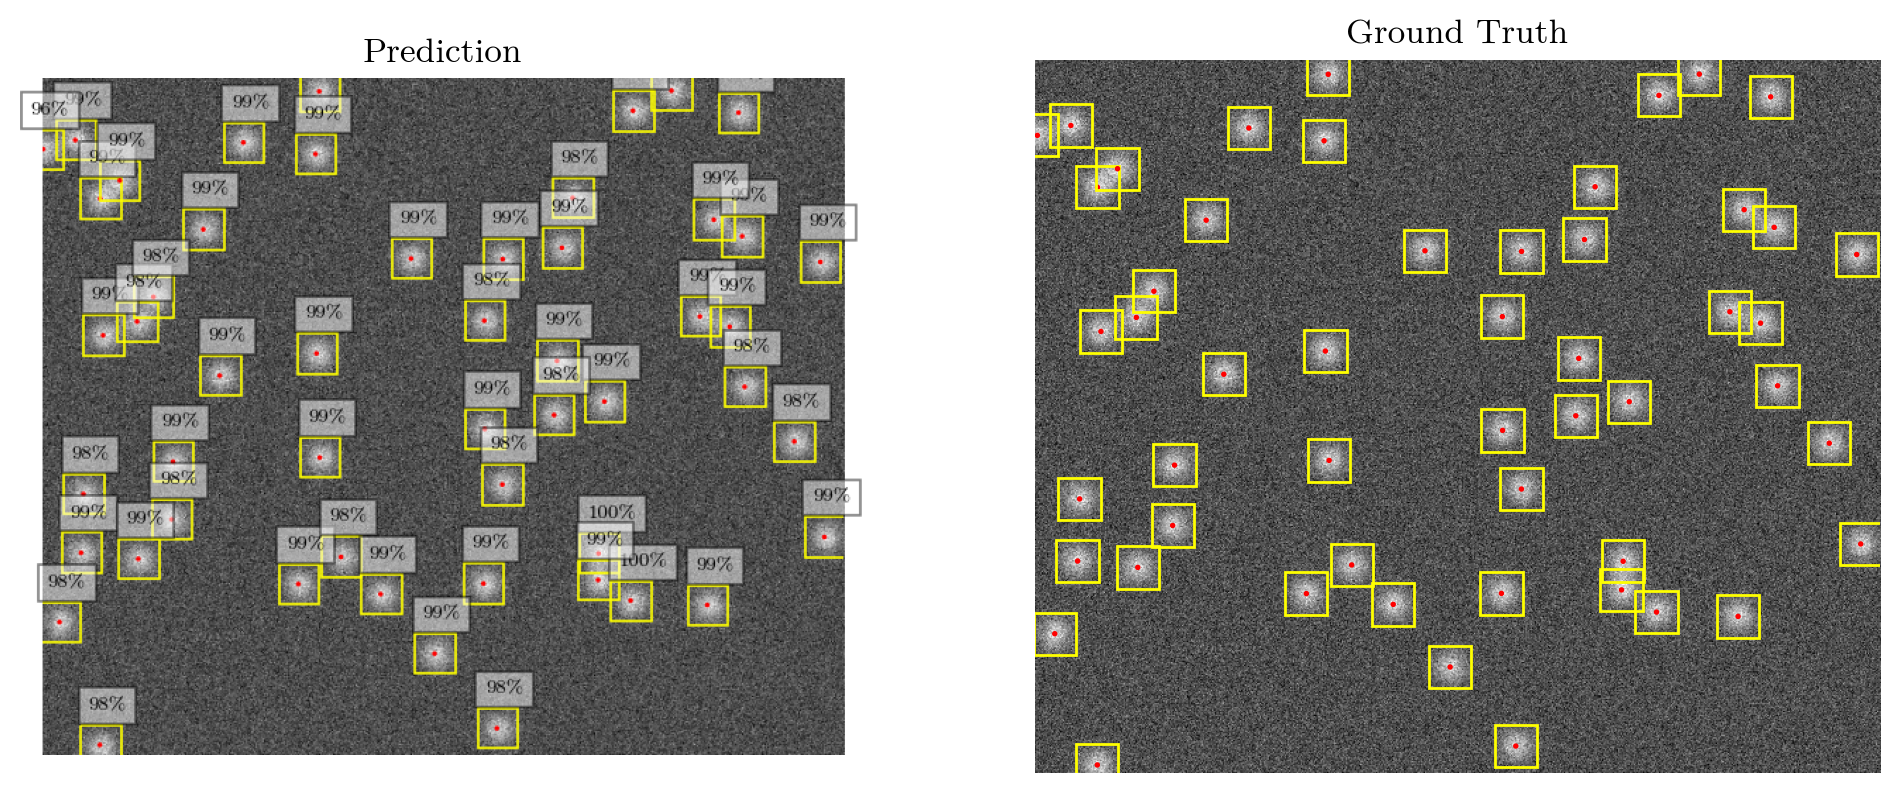

name  class  confidence  \
0   Spot      0     0.99845   
1   Spot      0     0.99575   
2   Spot      0     0.99341   
3   Spot      0     0.99340   
4   Spot      0     0.99296   
5   Spot      0     0.99206   
6   Spot      0     0.99162   
7   Spot      0     0.99160   
8   Spot      0     0.99157   
9   Spot      0     0.99149   
10  Spot      0     0.99061   
11  Spot      0     0.99020   
12  Spot      0     0.98983   
13  Spot      0     0.98970   
14  Spot      0     0.98932   
15  Spot      0     0.98884   
16  Spot      0     0.98853   
17  Spot      0     0.98843   
18  Spot      0     0.98834   
19  Spot      0     0.98788   
20  Spot      0     0.98779   
21  Spot      0     0.98762   
22  Spot      0     0.98760   
23  Spot      0     0.98745   
24  Spot      0     0.98725   
25  Spot      0     0.98724   
26  Spot      0     0.98722   
27  Spot      0     0.98686   
28  Spot      0     0.98666   
29  Spot      0     0.98648   
30  Spot      0     0.98607   
31  Spot      0     0.98605   
32  Spot      0     0.98550   
33  Spot      0     0.98520   
34  Spot      0     0.98503   
35  Spot      0     0.98499   
36  Spot      0     0.98470   
37  Spot      0     0.98459   
38  Spot      0     0.98358   
39  Spot      0     0.98357   
40  Spot      0     0.98343   
41  Spot      0     0.98319   
42  Spot      0     0.98151   
43  Spot      0     0.98086   
44  Spot      0     0.98065   
45  Spot      0     0.98032   
46  Spot      0     0.97986   
47  Spot      0     0.97956   
48  Spot      0     0.97920   
49  Spot      0     0.97641   
50  Spot      0     0.97594   
51  Spot      0     0.95577   

                                                  box  \
0   {'x1': 454.38867, 'y1': 401.5827, 'x2': 486.40...   
1   {'x1': 429.12033, 'y1': 363.26398, 'x2': 461.1...   
2   {'x1': 456.2196, 'y1': 10.27181, 'x2': 488.207...   
3   {'x1': 30.99963, 'y1': 80.36482, 'x2': 63.0684...   
4   {'x1': 11.29617, 'y1': 33.48018, 'x2': 43.2828...   
5   {'x1': 428.07178, 'y1': 384.62256, 'x2': 460.0...   
6   {'x1': 15.75287, 'y1': 362.80835, 'x2': 47.746...   
7   {'x1': 509.73969, 'y1': 174.45181, 'x2': 541.7...   
8   {'x1': 433.39673, 'y1': 242.21719, 'x2': 465.3...   
9   {'x1': 533.24207, 'y1': 182.69238, 'x2': 565.2...   
10  {'x1': 543.1864, 'y1': 110.34048, 'x2': 575.16...   
11  {'x1': 520.57391, 'y1': 97.08963, 'x2': 552.57...   
12  {'x1': 145.42633, 'y1': 35.57172, 'x2': 177.43...   
13  {'x1': 336.9281, 'y1': 387.3891, 'x2': 368.932...   
14  {'x1': 46.41614, 'y1': 66.05319, 'x2': 78.4793...   
15  {'x1': 113.28403, 'y1': 104.95433, 'x2': 145.2...   
16  {'x1': 33.51456, 'y1': 189.43661, 'x2': 65.510...   
17  {'x1': 515.76465, 'y1': 404.54803, 'x2': 547.7...   
18  {'x1': 205.86484, 'y1': -5.1156, 'x2': 237.871...   
19  {'x1': 189.1944, 'y1': 387.82385, 'x2': 221.19...   
20  {'x1': 206.36411, 'y1': 286.6189, 'x2': 238.35...   
21  {'x1': 608.91644, 'y1': 350.29907, 'x2': 640.9...   
22  {'x1': 203.92493, 'y1': 203.92267, 'x2': 235.9...   
23  {'x1': 126.61062, 'y1': 221.50766, 'x2': 158.6...   
24  {'x1': 89.15135, 'y1': 290.26636, 'x2': 121.12...   
25  {'x1': 337.82831, 'y1': 264.13217, 'x2': 369.8...   
26  {'x1': 605.66241, 'y1': 130.90872, 'x2': 637.6...   
27  {'x1': 399.47757, 'y1': 119.53226, 'x2': 431.4...   
28  {'x1': 297.89886, 'y1': 443.21854, 'x2': 329.9...   
29  {'x1': 254.87854, 'y1': 395.76569, 'x2': 286.8...   
30  {'x1': 61.62058, 'y1': 367.84253, 'x2': 93.626...   
31  {'x1': 202.87679, 'y1': 44.76674, 'x2': 234.90...   
32  {'x1': 395.59991, 'y1': 209.77979, 'x2': 427.5...   
33  {'x1': 352.12585, 'y1': 128.67172, 'x2': 384.1...   
34  {'x1': 279.09735, 'y1': 128.2417, 'x2': 311.09...   
35  {'x1': 223.25951, 'y1': 366.11719, 'x2': 255.2...   
36  {'x1': 351.91721, 'y1': 308.34253, 'x2': 383.9...   
37  {'x1': 408.10101, 'y1': 79.82852, 'x2': 440.10...   
38  {'x1': 540.46283, 'y1': 11.82071, 'x2': 572.46...   
39  {'x1': 87.99037, 'y1': 336.29224, 'x2': 119.99...   
40  {'x1': 584.92041, '

In [9]:
if not plt.get_fignums() : plt.figure(figsize=(12,5))
else: plt.clf()
image = random_image()
img = np.array(PIL.Image.open(image))
results, = model.predict(np.array(img), conf = 0.7, level=0, background=0)
# boxes2 = results.boxes2.cpu()
# results = results.cpu()

plt.subplot(1,2,1)
plt.title("Prediction")
kpt = results.keypoints
bbox = results.boxes

z = np.zeros((len(kpt)))
# plot_result(plt.gca(),img,z,bbox.xywh.cpu(),z,kpt.cpu(),conf=bbox.conf, vmin=None, vmax=None)
plt.imshow(results.plot())
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Ground Truth")
plot_gt(image,plt.gca(),imgsz, vmin=None, vmax=None)
plt.show()
results.to_df() #print results dataframe

Next, lets look at the validation scores

In [10]:
snr_range = [1,20]
snrlevels = np.linspace(*snr_range, 20)
r,xy_rms, z_rms, kpt_pairs = [],[],[],[]
for i, snr in enumerate(snrlevels):
    fname = f'../datasets/Dataset_spots/levels/dataset_test_snr{snr}.yaml'
    res = model.val(conf=0.9,data=fname, workers=0, background=0)
    r.append(res.all_box_results)
    xy_rms.append(res.xy_rms)
    z_rms.append(res.z_rms)
    kpt_pairs.append(res.kpt_pairs)

    del res

recall = np.array([res["r"] for res in r]).squeeze()
precision = np.array([res["p"] for res in r]).squeeze()

np.savez("spots_validation.npz", recall=recall, precision=precision, xy_rms=np.array(xy_rms))

Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr1.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.43it/s]

                   all       1000      60179      0.996      0.988      0.992      0.813   3.28e+04       1.77
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)



val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr2.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.83it/s]


                   all       1000      59890          1          1      0.995      0.945   3.28e+04      0.703
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr3.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.83it/s]


                   all       1000      59146          1          1      0.995      0.981   3.28e+04      0.449
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr4.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.85it/s]


                   all       1000      59792          1          1      0.995      0.992   3.28e+04      0.336
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr5.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.79it/s]


                   all       1000      59366          1          1      0.995      0.995   3.28e+04      0.272
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr6.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.78it/s]


                   all       1000      60315          1          1      0.995      0.995   3.28e+04      0.233
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr7.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.67it/s]


                   all       1000      60693          1          1      0.995      0.995   3.28e+04      0.205
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr8.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.84it/s]


                   all       1000      59994          1          1      0.995      0.995   3.28e+04      0.184
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr9.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.76it/s]


                   all       1000      60798          1          1      0.995      0.995   3.28e+04      0.168
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr10.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.12it/s]


                   all       1000      59803          1          1      0.995      0.995   3.28e+04      0.157
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr11.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.67it/s]


                   all       1000      60149          1          1      0.995      0.995   3.28e+04      0.146
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr12.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.76it/s]


                   all       1000      60333          1          1      0.995      0.995   3.28e+04      0.139
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr13.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.68it/s]


                   all       1000      59609          1          1      0.995      0.995   3.28e+04      0.132
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr14.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.78it/s]


                   all       1000      59375          1          1      0.995      0.995   3.28e+04      0.128
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr15.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.66it/s]


                   all       1000      59628          1          1      0.995      0.995   3.28e+04      0.123
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr16.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.67it/s]


                   all       1000      60449          1          1      0.995      0.995   3.28e+04       0.12
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr17.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.58it/s]


                   all       1000      60427          1          1      0.995      0.995   3.28e+04      0.116
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr18.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.27it/s]


                   all       1000      59911          1          1      0.995      0.995   3.28e+04      0.114
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr19.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.39it/s]


                   all       1000      59731          1          1      0.995      0.995   3.28e+04      0.111
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_spots/labels/test_snr20.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 63/63 [00:04<00:00, 14.24it/s]


                   all       1000      59596          1          1      0.995      0.995   3.28e+04      0.108
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image


[[ 1.6734e+09           0]
 [          0  1.6734e+09]]
CRLB (x,y) at SNR=1: [    0.80103     0.40052     0.26701     0.20026     0.16021     0.13351     0.11443     0.10013    0.089004    0.080103    0.072821    0.066753    0.061618    0.057217    0.053402    0.050065     0.04712    0.044502     0.04216    0.040052]


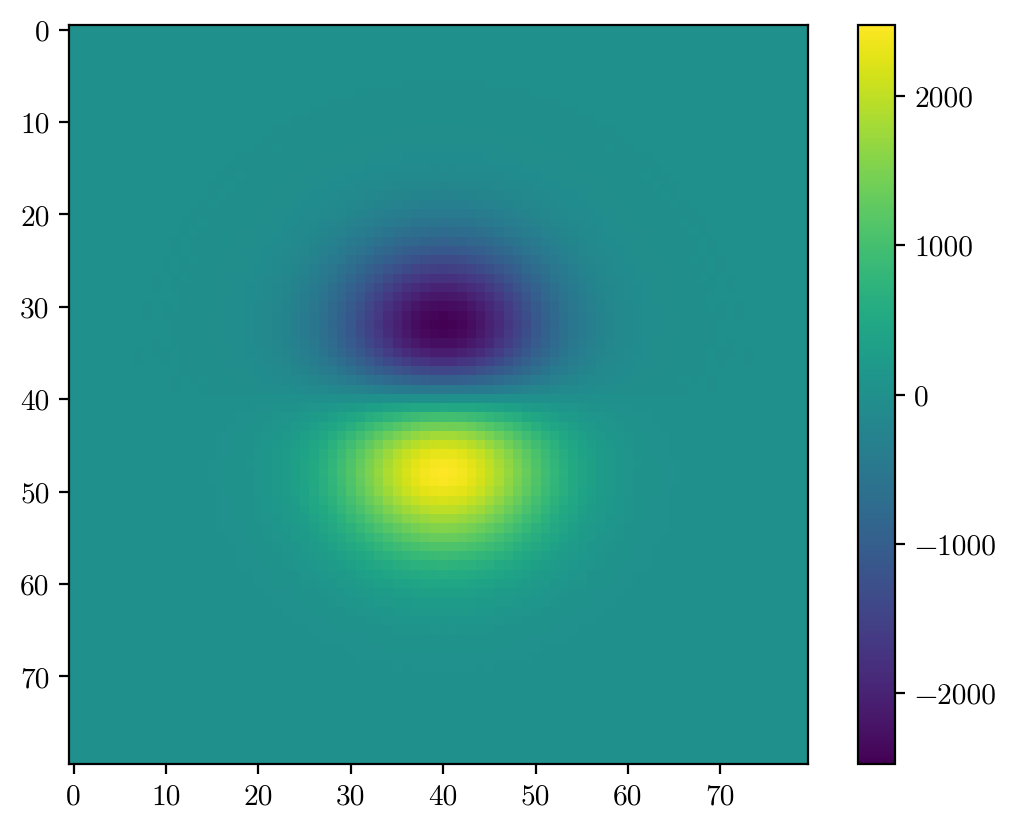

In [11]:
# calculate the CRLB
import image_generator as ig
objects = ig.pd.DataFrame({"label":"Spot", "i":2**15, "s":8, "x":40,"y":40}, index=[0])
img, _ = ig.generateImage(objects, (80,80),noise=0, refstack=np.zeros((40,40,40)), background=0)
# img += 2e4
# img /= img.max()
# print(img.max())
img = img.round().astype(np.uint16)
def derivative(psf, axis, delta=0.1): # delta : small shift in x or y
    shift_vec = [0, 0]
    shift_vec[axis] = delta
    psf_forward = (1-delta)*psf+(delta*np.roll(psf, shift=1, axis=axis)).round().astype(np.uint16)
    shift_vec[axis] = -delta
    psf_backward = (1-delta)*psf+(delta*np.roll(psf, shift=-1, axis=axis)).round().astype(np.uint16)
    return (psf_forward - psf_backward) / (2 * delta)
dh_dx = derivative(img, axis=1)  # x-axis derivative
dh_dy = derivative(img, axis=0)  # y-axis derivative
plt.imshow(dh_dy)
plt.colorbar()
# Compute Fisher Information Matrix (FIM)
I_xx =  np.sum(dh_dx**2)
I_yy =  np.sum(dh_dy**2)


I_xy =  np.sum(dh_dx * dh_dy)

FIM = np.array([[I_xx, I_xy],
                [I_xy, I_yy]])
print(FIM)
CRLB_0 = np.sqrt(np.diag(np.linalg.inv(FIM)))
snr_range = [1,20]
snrlevels = np.linspace(*snr_range, 20)
CRLB = np.sqrt((2**15/np.array(snrlevels))**2+1/12) * np.mean(CRLB_0)
print(f"CRLB (x,y) at SNR=1: {CRLB}")

In [12]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def place_images(ax, images, xmin=0.05,xmax=0.95, vmin=None, vmax=None):
    x_range = np.linspace(xmin, xmax, 11)
    for x, image in zip(x_range, images):
        im = OffsetImage(image, zoom=0.32, cmap="gray")
        if vmin is not None and vmax is not None:
            im.get_children()[0].set_clim(vmin, vmax)
        ab = AnnotationBbox(im, (x, 0), xycoords="axes fraction", frameon=False, pad=0, box_alignment=(0.5, 0))
        ax.add_artist(ab)

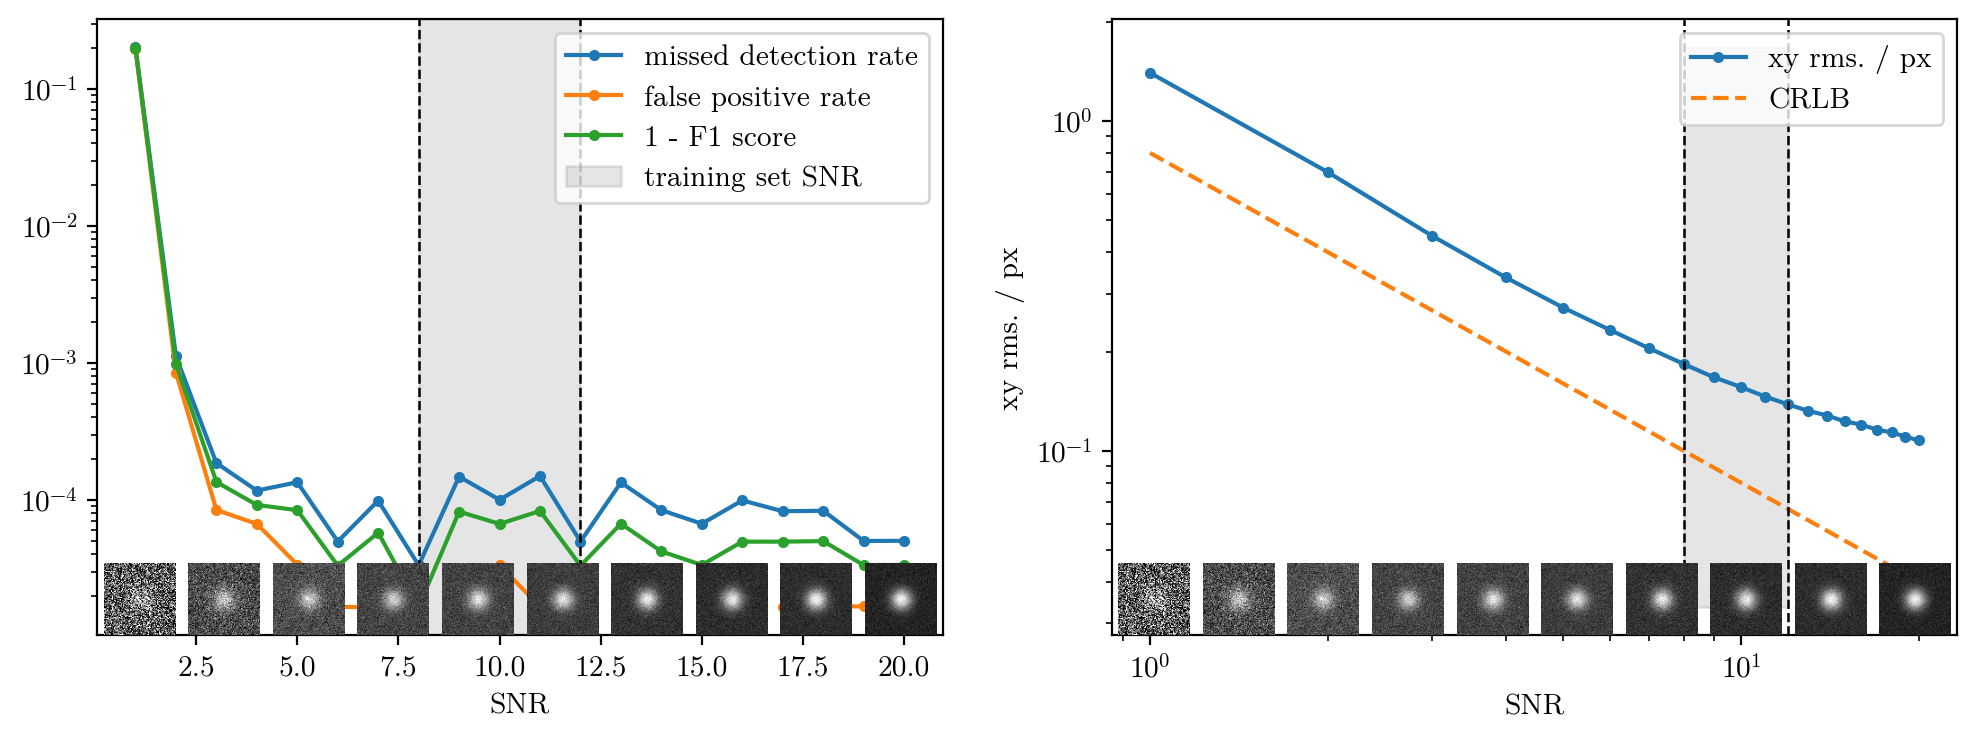

/tmp/ipykernel_3742084/1627014097.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


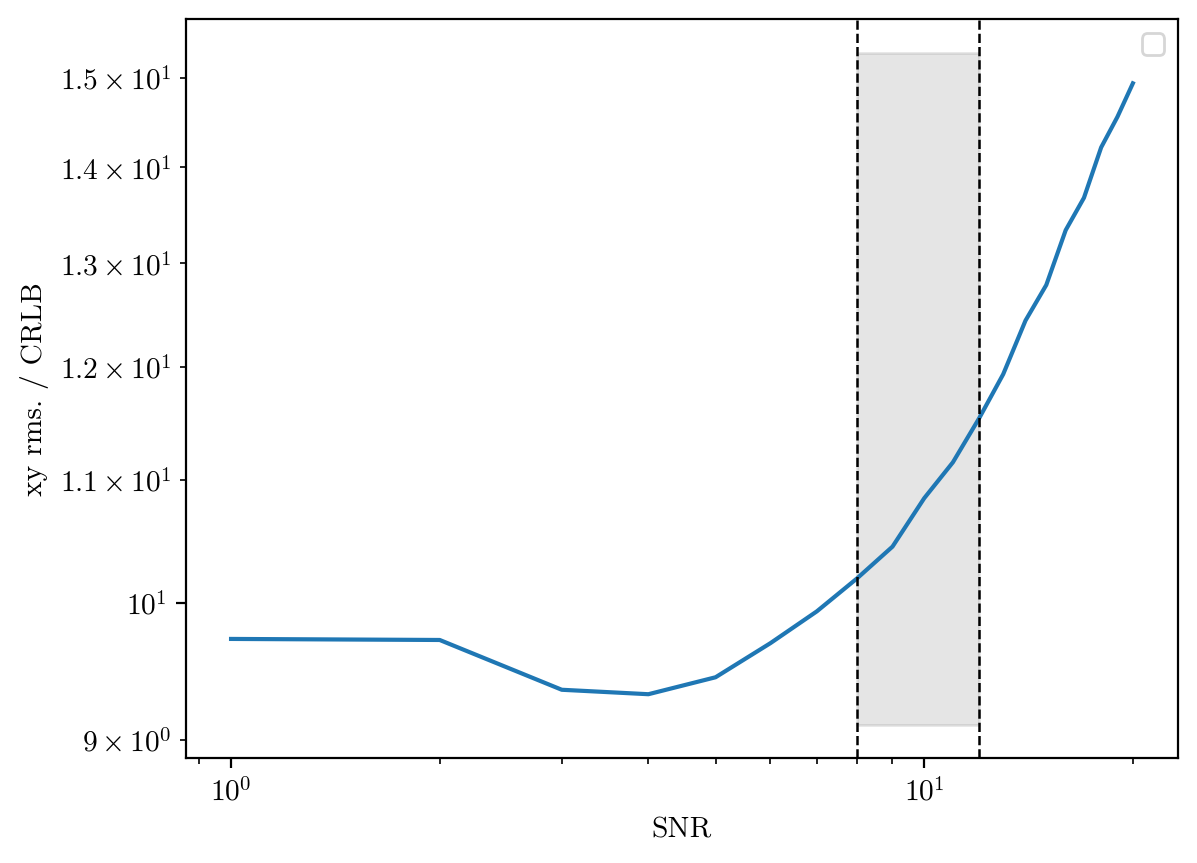

In [13]:
recall = np.array([res["r"] for res in r]).squeeze()
precision = np.array([res["p"] for res in r]).squeeze()
f1 = 2 * (recall * precision) / (recall + precision)

images = [PIL.Image.open(f"spot_at_snr/{snr}.png") for snr in np.linspace(1,20,20)[::2]]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
place_images(plt.gca(), images, xmin=0.05,xmax=1.05)
plt.plot(snrlevels, 1-recall[:,7], ".-",label="missed detection rate")
plt.plot(snrlevels, 1-precision[:,7], ".-",label="false positive rate")
plt.plot(snrlevels, 1-f1[:,7], ".-",label="1 - F1 score")
plt.xlabel("SNR")
# plt.xscale("log")
plt.yscale("log")
plt.ylim(*plt.ylim()) #quick fix to fix fill
plt.axvline(8,0,1,ls="dashed", lw=0.9,c="k")
plt.axvline(12,0,1,ls="dashed", lw=0.9,c="k")
plt.fill_between((8,12),*plt.ylim(), color="grey", alpha=0.2,label="training set SNR")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
place_images(plt.gca(), images, xmin=0.05,xmax=1.05)
plt.plot(snrlevels, np.array(xy_rms)[:,7], ".-",label="xy rms. / px")
plt.plot(snrlevels, CRLB, "--", label="CRLB")
plt.legend(loc="upper right")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("SNR")
plt.ylabel("xy rms. / px")
# plt.ylim(0.3e-1,2) #quick fix to fix fill
plt.axvline(8,0,1,ls="dashed", lw=0.9,c="k")
plt.axvline(12,0,1,ls="dashed", lw=0.9,c="k", label="training set SNR")
plt.fill_between((8,12),*plt.ylim(), color="grey", alpha=0.2)
plt.show()

plt.figure()

# place_images(plt.gca(), images, xmin=0.05,xmax=1.05)
plt.plot(snrlevels, np.array(xy_rms)[:,7]/(1/snrlevels * CRLB.mean()))
plt.legend(loc="upper right")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("SNR")
plt.ylabel("xy rms. / CRLB")
# plt.ylim(0.3e-1,2) #quick fix to fix fill
plt.axvline(8,0,1,ls="dashed", lw=0.9,c="k")
plt.axvline(12,0,1,ls="dashed", lw=0.9,c="k", label="training set SNR")
plt.fill_between((8,12),*plt.ylim(), color="grey", alpha=0.2)
plt.show()

It seems, we are proportional to the theoretical limit at first, but plateau at an rms ~0.1px for low noise. This might be because we have not trained in the high noise region, but compared to https://doi.org/10.1038/s41467-022-35004-y, where they train on similar noise, our performance is worse.

Text(0.5, 0, 'SNR')

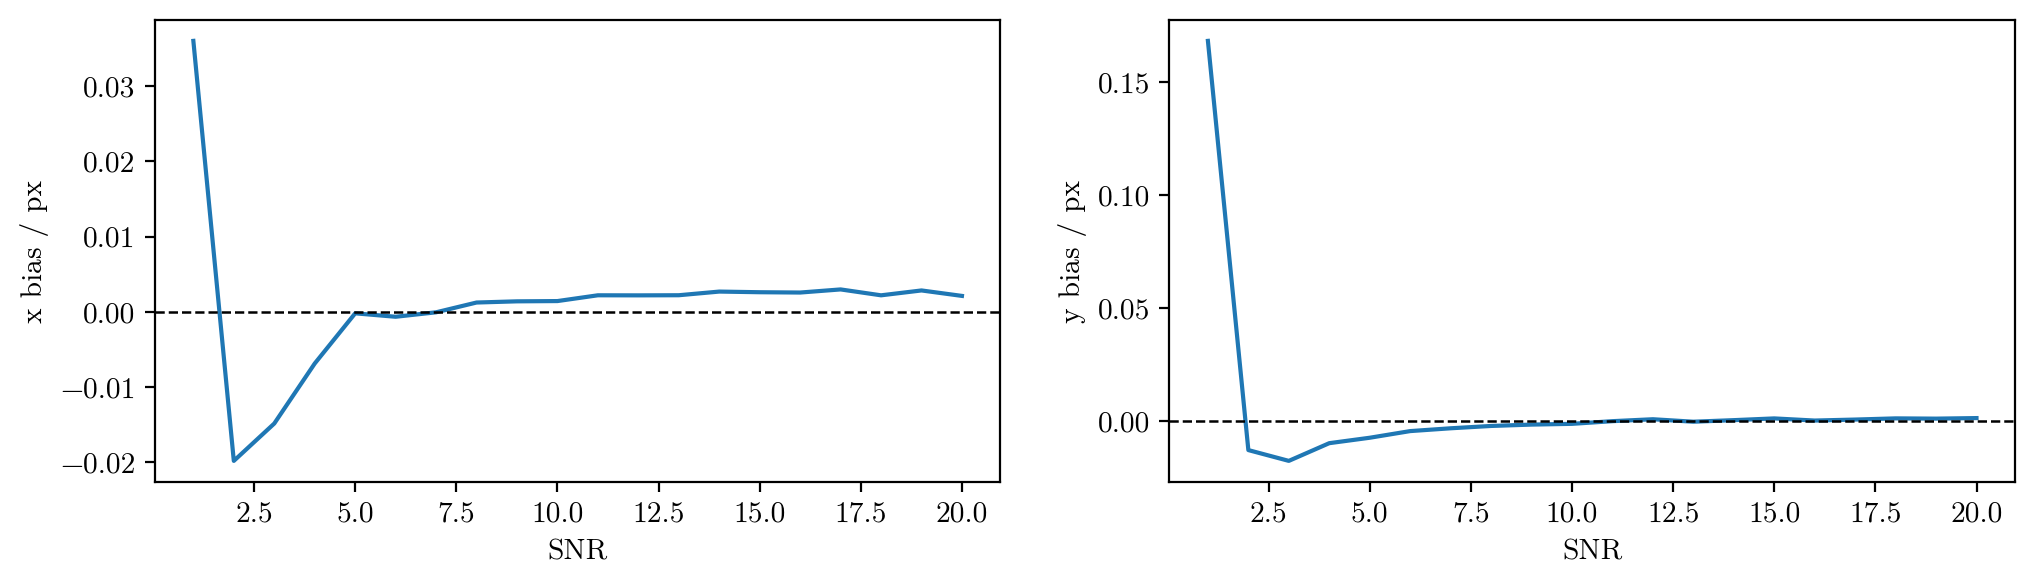

In [14]:
plt.figure(figsize=(12,3))
x_bias = [np.mean(np.subtract(*kpt[6][0])) for kpt in kpt_pairs]
y_bias = [np.mean(np.subtract(*kpt[6][1])) for kpt in kpt_pairs]
plt.subplot(121)
plt.plot(snrlevels, x_bias)
plt.ylabel("x bias / px")
plt.axhline(0,0,1, lw=0.9,ls="--",c="k")
plt.xlabel("SNR")
plt.subplot(122)

plt.plot(snrlevels, y_bias)
plt.axhline(0,0,1, lw=0.9,ls="--",c="k")
plt.ylabel("y bias / px")
plt.xlabel("SNR")

No significant bias